# 2. Chlorophyll-a and Temperature Correlations

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.spatial import cKDTree
from scipy.stats import spearmanr

import urllib.request
import datetime as dt

import netCDF4
from netCDF4 import Dataset, num2date

from matplotlib import pyplot as plt
%matplotlib inline

## Load the dataset from the csv file

In [2]:
df = pd.read_csv('RAW COMBINED DATA.csv')

## Clean up and pivot the dataframe

In [3]:
df1 = df.drop(columns=['Depth','Latitude','Longitude','median','p5','p95','lowest','highest']).rename(columns={"mean": "Value"}).set_index(["Site Name", "Date"]).pivot(columns="Variable")['Value'].reset_index().rename_axis(None, axis=1)
df1

,Site Name,Date,Chl_a_sum,DIC,DIP,PAR,PH,SST,Salinity,Temp,Total_Nitrogen,WS_u,WS_v
0,Site A,2011-01-01,1.593400,23264.13033,4.593337,0.000044,8.123843,26.472911,35.514774,21.548902,91.066483,-5.584072,1.927125
1,Site A,2011-02-01,1.178931,23201.26594,3.314823,0.000050,8.113303,27.331098,35.478463,22.992727,80.496338,-3.962147,0.944716
2,Site A,2011-03-01,1.019666,23080.68346,4.986534,0.000033,8.088158,27.078977,35.504641,24.553983,97.506236,-3.474723,1.007745
3,Site A,2011-04-01,1.118257,23121.66848,5.616589,0.000026,8.090884,26.040695,35.438912,24.351538,101.215224,-4.370092,4.096774
4,Site A,2011-05-01,0.585132,23280.78416,1.851396,0.000025,8.095257,24.170828,35.496033,23.837653,66.428991,0.448532,3.910924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,Site E,2018-08-01,0.394180,23029.49614,1.258282,0.000023,8.097806,25.130686,35.226449,24.860653,58.977623,-6.309957,5.065163
476,Site E,2018-09-01,0.376906,23099.83955,0.730994,0.000036,8.091863,25.073075,35.252890,24.796843,53.927021,-7.234225,5.335747
477,Site E,2018-10-01,0.428957,23005.15362,0.425672,0.000037,8.095646,25.778672,35.310891,24.984308,53.953252,-5.743962,3.482013
478,Site E,2018-11-01,0.532191,23007.50178,0.350171,0.000053,8.083797,27.599377,35.268250,26.037196,53.595734,-4.367141,1.958173


## Create unique dataframes for each site

In [4]:
dfA = df1[(df1['Site Name'] == "Site A")]
dfB = df1[(df1['Site Name'] == "Site B")]
dfC = df1[(df1['Site Name'] == "Site C")]
dfD = df1[(df1['Site Name'] == "Site D")]
dfE = df1[(df1['Site Name'] == "Site E")]

### Define time lag correlation

Chlorophyll-a levels lag behind temperature changes, and it is important to account for this in correlation calculations.

In [5]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datay.corr(datax.shift(lag),method="spearman")

# 2.1 -60m Temperature and Chlorophyll-a

### Determine best time lags for -60m temperature

In [6]:
#Site A
xcov_monthlyA = [crosscorr(dfA['Temp'], dfA['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npA = np.array(xcov_monthlyA) 

#Site B
xcov_monthlyB = [crosscorr(dfB['Temp'], dfB['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npB = np.array(xcov_monthlyB) 

#Site C
xcov_monthlyC = [crosscorr(dfC['Temp'], dfC['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npC = np.array(xcov_monthlyC) 

#Site D
xcov_monthlyD = [crosscorr(dfD['Temp'], dfD['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npD = np.array(xcov_monthlyD) 

#Site E
xcov_monthlyE = [crosscorr(dfE['Temp'], dfE['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npE = np.array(xcov_monthlyE) 

#Results
print('Site A: Maximum negative correlation value',xcov_monthly_npA.min(),' - best lag',np.argmin(xcov_monthly_npA),'months')
print('Site B: Maximum negative correlation value',xcov_monthly_npB.min(),' - best lag',np.argmin(xcov_monthly_npB),'months')
print('Site C: Maximum negative correlation value',xcov_monthly_npC.min(),' - best lag',np.argmin(xcov_monthly_npC),'months')
print('Site D: Maximum negative correlation value',xcov_monthly_npD.min(),' - best lag',np.argmin(xcov_monthly_npD),'months')
print('Site E: Maximum negative correlation value',xcov_monthly_npE.min(),' - best lag',np.argmin(xcov_monthly_npE),'months')


Site A: Maximum negative correlation value -0.5390961962215077  - best lag 2 months
Site B: Maximum negative correlation value -0.5927320015894232  - best lag 2 months
Site C: Maximum negative correlation value -0.8381967272333202  - best lag 2 months
Site D: Maximum negative correlation value -0.6311360448807855  - best lag 4 months
Site E: Maximum negative correlation value -0.4209268991877687  - best lag 4 months


### Define interval shifts based on best lag

This allows us to plot the time lagged temperature data against the chlorophyll-a data.

In [7]:
dfA['Temp_Lag_2'] = dfA['Temp'].shift(2)
dfB['Temp_Lag_2'] = dfB['Temp'].shift(2)
dfC['Temp_Lag_2'] = dfC['Temp'].shift(2)
dfD['Temp_Lag_4'] = dfD['Temp'].shift(4)
dfE['Temp_Lag_4'] = dfE['Temp'].shift(4)

/tmp/ipykernel_164/4264445947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfA['Temp_Lag_2'] = dfA['Temp'].shift(2)
/tmp/ipykernel_164/4264445947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfB['Temp_Lag_2'] = dfB['Temp'].shift(2)
/tmp/ipykernel_164/4264445947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

### Plot chlorophyll-a and -60m temperature with best time lag

<AxesSubplot:>

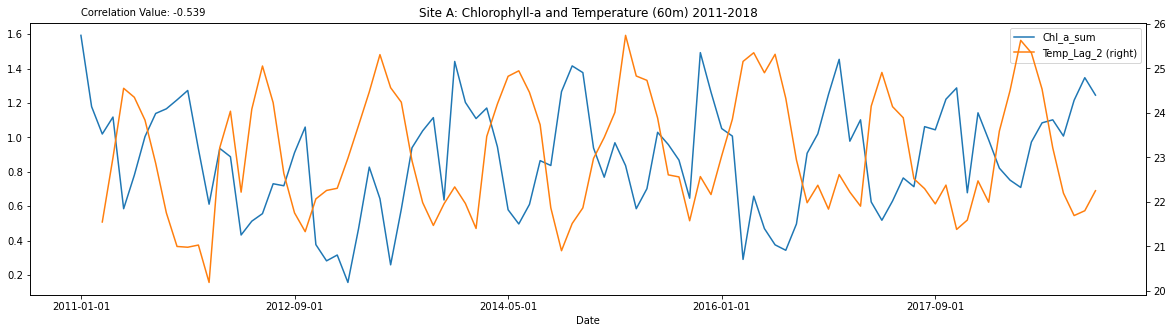

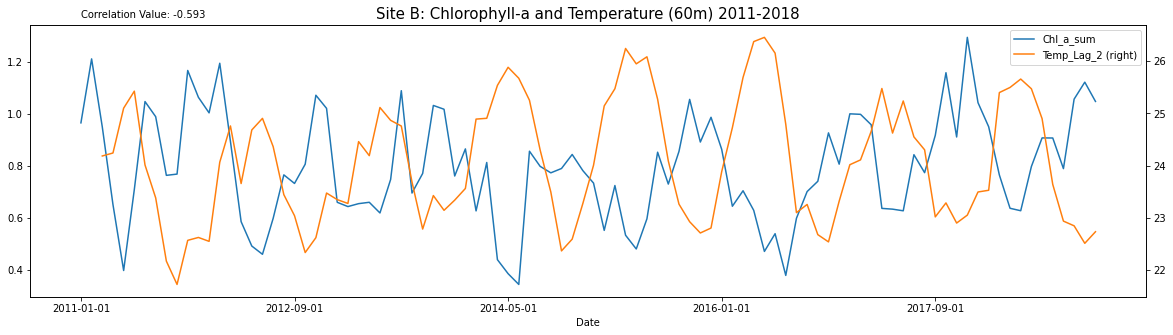

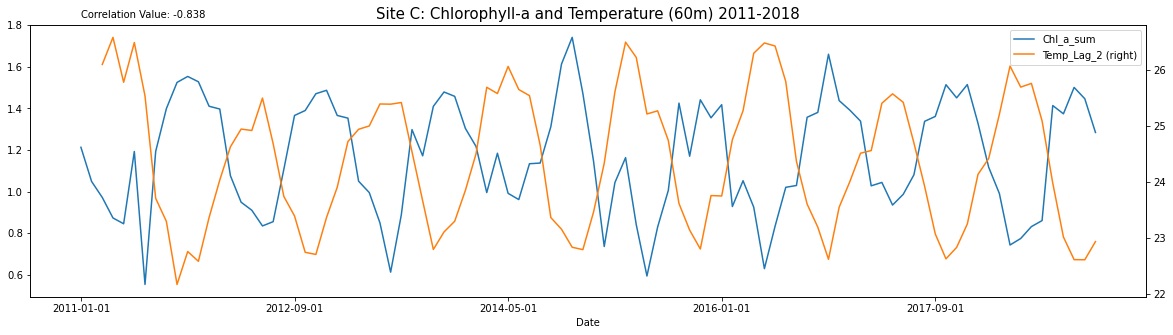

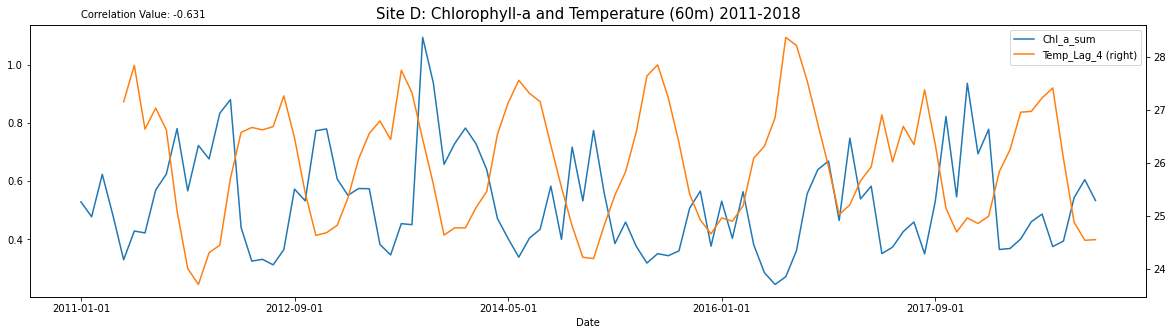

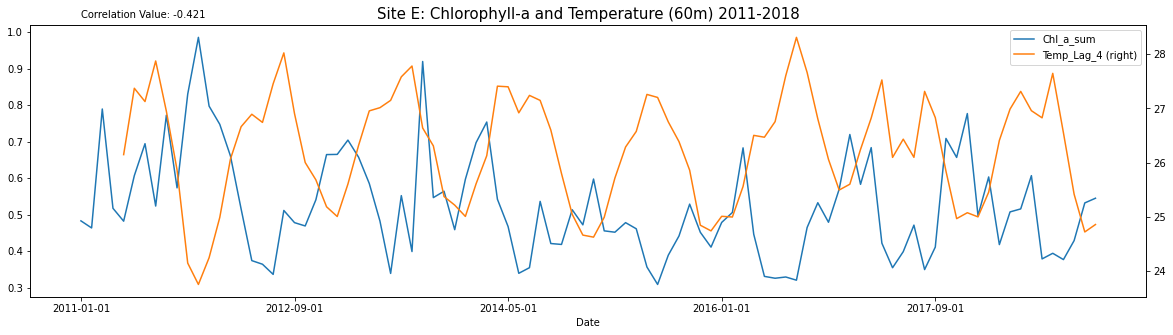

In [8]:
#Site A

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site A: Chlorophyll-a and Temperature (60m) 2011-2018',fontsize=12)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.539')
dfA.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfA.plot(x = 'Date', y = 'Temp_Lag_2', ax = ax, secondary_y = True)


#Site B

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site B: Chlorophyll-a and Temperature (60m) 2011-2018',fontsize=15)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.593')
dfB.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfB.plot(x = 'Date', y = 'Temp_Lag_2', ax = ax, secondary_y = True)

#Site C

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site C: Chlorophyll-a and Temperature (60m) 2011-2018',fontsize=15)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.838')
dfC.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfC.plot(x = 'Date', y = 'Temp_Lag_2', ax = ax, secondary_y = True)

#Site D

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site D: Chlorophyll-a and Temperature (60m) 2011-2018',fontsize=15)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.631')
dfD.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfD.plot(x = 'Date', y = 'Temp_Lag_4', ax = ax, secondary_y = True) 

#Site E

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site E: Chlorophyll-a and Temperature (60m) 2011-2018',fontsize=15)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.421')
dfE.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfE.plot(x = 'Date', y = 'Temp_Lag_4', ax = ax, secondary_y = True) 

# 2.2 Sea Surface Temperature and Chlorophyll-a

### Determine best time lags for SST

In [9]:
#Site A
xcov_monthlyA2 = [crosscorr(dfA['SST'], dfA['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npA2 = np.array(xcov_monthlyA2) 

#Site B
xcov_monthlyB2 = [crosscorr(dfB['SST'], dfB['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npB2 = np.array(xcov_monthlyB2) 

#Site C
xcov_monthlyC2 = [crosscorr(dfC['SST'], dfC['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npC2 = np.array(xcov_monthlyC2) 

#Site D
xcov_monthlyD2 = [crosscorr(dfD['SST'], dfD['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npD2 = np.array(xcov_monthlyD2) 

#Site E
xcov_monthlyE2 = [crosscorr(dfE['SST'], dfE['Chl_a_sum'], lag=i) for i in range(12)]
xcov_monthly_npE2 = np.array(xcov_monthlyE2) 

#Results
print('Site A: Maximum negative correlation value',xcov_monthly_npA2.min(),' - best lag',np.argmin(xcov_monthly_npA2),'months')
print('Site B: Maximum negative correlation value',xcov_monthly_npB2.min(),' - best lag',np.argmin(xcov_monthly_npB2),'months')
print('Site C: Maximum negative correlation value',xcov_monthly_npC2.min(),' - best lag',np.argmin(xcov_monthly_npC2),'months')
print('Site D: Maximum negative correlation value',xcov_monthly_npD2.min(),' - best lag',np.argmin(xcov_monthly_npD2),'months')
print('Site E: Maximum negative correlation value',xcov_monthly_npE2.min(),' - best lag',np.argmin(xcov_monthly_npE2),'months')

Site A: Maximum negative correlation value -0.551818805765271  - best lag 3 months
Site B: Maximum negative correlation value -0.6746889081197218  - best lag 3 months
Site C: Maximum negative correlation value -0.8660738265047296  - best lag 3 months
Site D: Maximum negative correlation value -0.6751383259097143  - best lag 4 months
Site E: Maximum negative correlation value -0.5250676859372513  - best lag 5 months


### Define interval shifts for plot based on best lag

In [10]:
dfA['SST_Lag_3'] = dfA['SST'].shift(3)
dfB['SST_Lag_3'] = dfB['SST'].shift(3)
dfC['SST_Lag_3'] = dfC['SST'].shift(3)
dfD['SST_Lag_4'] = dfD['SST'].shift(4)
dfE['SST_Lag_5'] = dfE['SST'].shift(5)

/tmp/ipykernel_164/2983455476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfA['SST_Lag_3'] = dfA['SST'].shift(3)
/tmp/ipykernel_164/2983455476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfB['SST_Lag_3'] = dfB['SST'].shift(3)
/tmp/ipykernel_164/2983455476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

### Plot chlorophyll-a and -60m temperature with best time lag

<AxesSubplot:>

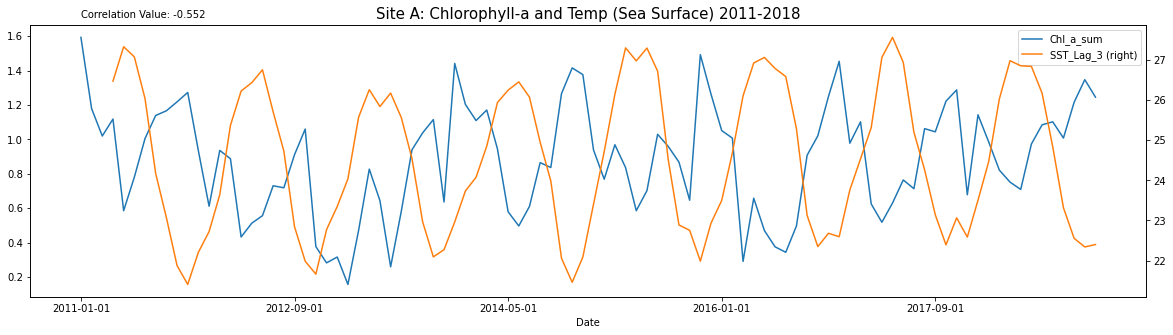

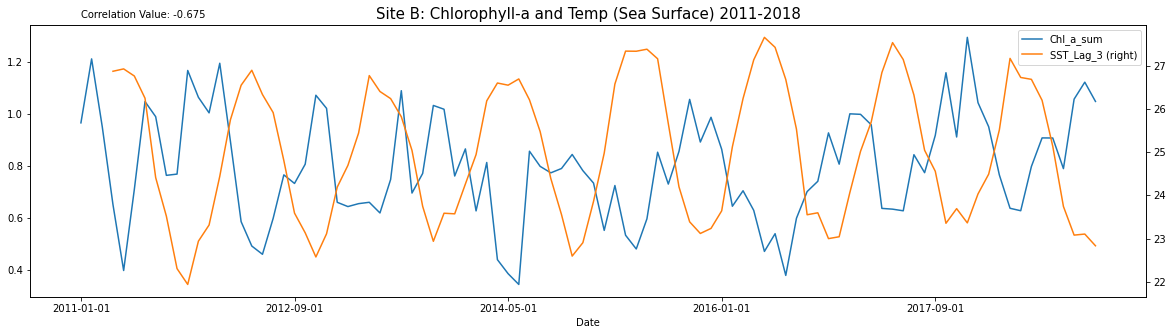

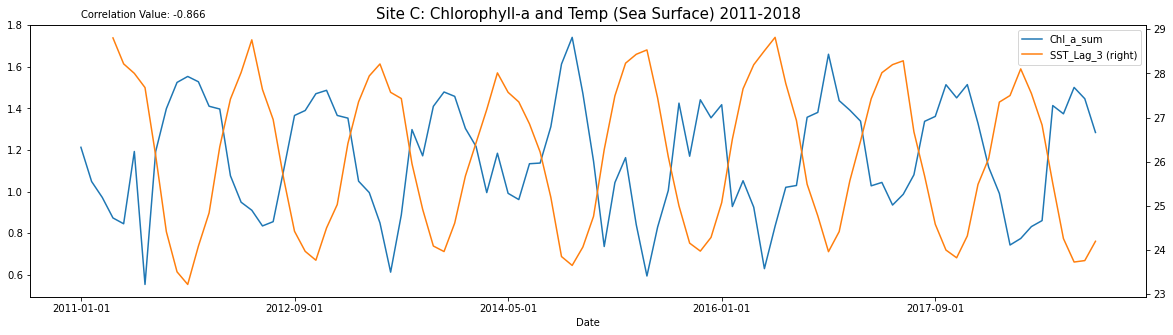

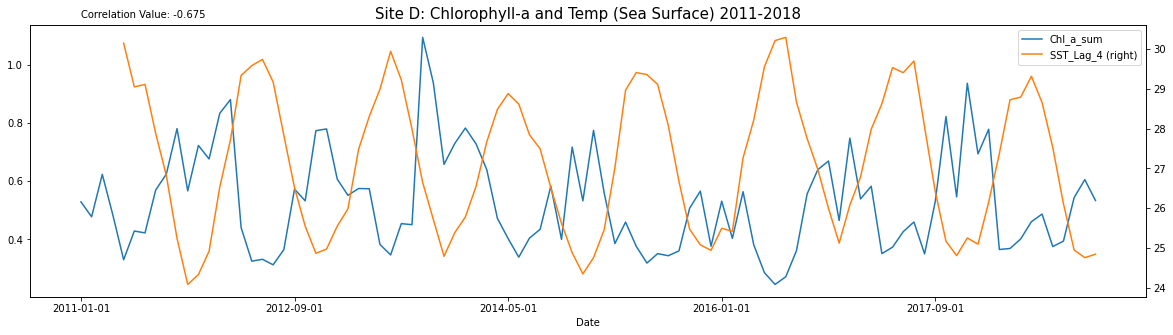

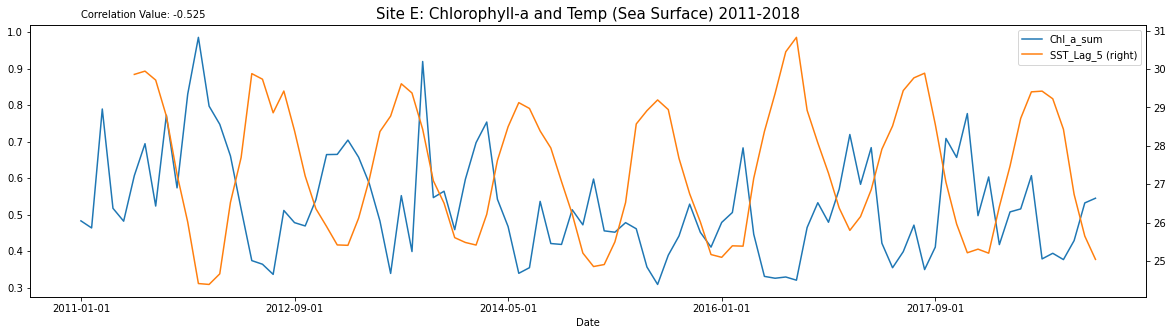

In [11]:
#Site A

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site A: Chlorophyll-a and Temp (Sea Surface) 2011-2018',fontsize=15)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.552')
dfA.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfA.plot(x = 'Date', y = 'SST_Lag_3', ax = ax, secondary_y = True)


#Site B

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site B: Chlorophyll-a and Temp (Sea Surface) 2011-2018',fontsize=15)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.675')
dfB.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfB.plot(x = 'Date', y = 'SST_Lag_3', ax = ax, secondary_y = True) 

#Site C

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site C: Chlorophyll-a and Temp (Sea Surface) 2011-2018',fontsize=15)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.866')
dfC.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfC.plot(x = 'Date', y = 'SST_Lag_3', ax = ax, secondary_y = True) 

#Site D

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site D: Chlorophyll-a and Temp (Sea Surface) 2011-2018',fontsize=15)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.675')
dfD.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfD.plot(x = 'Date', y = 'SST_Lag_4', ax = ax, secondary_y = True) 

#Site E

fig, ax = plt.subplots() 
fig.set_size_inches(20, 5)
plt.title('Site E: Chlorophyll-a and Temp (Sea Surface) 2011-2018',fontsize=15)
plt.figtext(0.16, 0.9, 'Correlation Value: -0.525')
dfE.plot(x = 'Date', y = 'Chl_a_sum', ax = ax) 
dfE.plot(x = 'Date', y = 'SST_Lag_5', ax = ax, secondary_y = True)

Figures clearly demonstrated an inverse (negative) correlation between temperature variables (both at -60m and at the sea surface) and chlroophyll-a levels. SST correlation is slightly stronger than temperature at depth.

# 2.3 Create scatterplots for temperature and chlorophyll-a at all sites

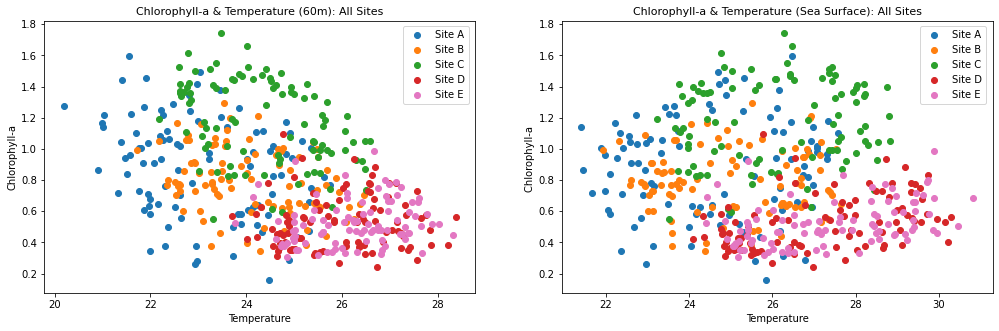

In [12]:
fig, axes = plt.subplots(figsize=(17, 5), ncols=2)
ax1, ax2 = axes

#60m Temperature

ax1.set_xlabel('Temperature')
ax1.set_ylabel('Chlorophyll-a')
ax1.set_title('Chlorophyll-a & Temperature (60m): All Sites',fontsize=11)
ax1.scatter(dfA["Temp"], dfA["Chl_a_sum"], color='tab:blue', label="Site A")
ax1.scatter(dfB["Temp"], dfB["Chl_a_sum"], color='tab:orange', label="Site B") 
ax1.scatter(dfC["Temp"], dfC["Chl_a_sum"], color='tab:green', label="Site C") 
ax1.scatter(dfD["Temp"], dfD["Chl_a_sum"], color='tab:red', label="Site D")
ax1.scatter(dfE["Temp"], dfE["Chl_a_sum"], color='tab:pink', label="Site E") 
ax1.legend(bbox_to_anchor=(0.82, 1))


#Sea Surface Temperature

ax2.set_xlabel('Temperature')
ax2.set_ylabel('Chlorophyll-a ')
ax2.set_title('Chlorophyll-a & Temperature (Sea Surface): All Sites',fontsize=11)
ax2.scatter(dfA["SST"], dfA["Chl_a_sum"], color='tab:blue', label="Site A")
ax2.scatter(dfB["SST"], dfB["Chl_a_sum"], color='tab:orange', label="Site B") 
ax2.scatter(dfC["SST"], dfC["Chl_a_sum"], color='tab:green', label="Site C") 
ax2.scatter(dfD["SST"], dfD["Chl_a_sum"], color='tab:red', label="Site D")
ax2.scatter(dfE["SST"], dfE["Chl_a_sum"], color='tab:pink', label="Site E") 
ax2.legend(bbox_to_anchor=(0.82, 1))

Scatterplots show the spatial variation in both temperature and chlorophyll-a abundance. Cooler waters demonstrate generally higher levels of chlorophyll-a, while warmer waters have lower chlorophyll-a activity.